In [1]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imageio


Note: you may need to restart the kernel to use updated packages.


In [3]:
#importing libraries
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
%matplotlib inline

import imageio.v2 as imageio

import os, shutil
from os import listdir, path


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install opencv-python



In [6]:
import tensorflow as tf
import os
import cv2

2024-05-05 18:41:24.278156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 18:41:25.516200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
augmented_data_path = '/teamspace/uploads/Augmented Data'


In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

augmented_data_path = '/teamspace/uploads/Augmented Data'

# Collect all the image file paths and their labels
image_files = []
labels = []

# os.listdir is used here to list all files in the directory
for file in os.listdir(augmented_data_path):
    if file.endswith('.jpeg'):  # Check for jpeg images
        image_files.append(os.path.join(augmented_data_path, file))
        labels.append(0 if 'Benign' in file else 1)  # Check for 'Benign' or 'Malignant' in the filename

# Check if the lists are populated
if not image_files:
    raise ValueError("No images found. Check the directory path and file naming convention.")

# Split the data into training+validation sets and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    image_files, labels, test_size=0.1, random_state=42, stratify=labels)  # 10% data as test set

# Split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.22, random_state=42, stratify=y_temp)  # 22% of remaining data as validation set

# Convert the lists into Pandas DataFrames for easier manipulation
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

# ... proceed to use train_df and val_df for training and validation,
# and test_df to evaluate the model after training


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
# Define image dimensions and batch size
img_width, img_height = 150, 150  # Resize images if necessary
batch_size = 32
# Convert class labels to string to fix the TypeError
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

# Define ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Define the ImageDataGenerator for the test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # Set shuffle to False for consistent order of evaluation



Found 4570 validated image filenames belonging to 2 classes.
Found 1289 validated image filenames belonging to 2 classes.
Found 651 validated image filenames belonging to 2 classes.


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-05 18:41:31.815487: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75759616 exceeds 10% of free system memory.
2024-05-05 18:41:31.877811: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75759616 exceeds 10% of free system memory.
2024-05-05 18:41:31.902478: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75759616 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(val_df) // batch_size
)


Epoch 1/10


2024-05-05 18:41:35.527499: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75759616 exceeds 10% of free system memory.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-05 18:41:46.320448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-05-05 18:41:47.653299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-05 18:41:47.654684: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89718784 exceeds 10% of free system memory.


142/142 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.6320 - loss: 0.6494 - val_accuracy: 0.6625 - val_loss: 0.5209
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.5625 - loss: 0.6343 - val_accuracy: 0.3333 - val_loss: 0.6613
Epoch 3/10


2024-05-05 18:47:03.054915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-05 18:47:03.109178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 137s 935ms/step - accuracy: 0.6492 - loss: 0.5475 - val_accuracy: 0.6883 - val_loss: 0.5213
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - accuracy: 0.5625 - loss: 0.6112 - val_accuracy: 0.6667 - val_loss: 0.6674
Epoch 5/10


2024-05-05 18:49:20.732294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:49:20.775685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 137s 940ms/step - accuracy: 0.6611 - loss: 0.5407 - val_accuracy: 0.6820 - val_loss: 0.5116
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - accuracy: 0.7812 - loss: 0.3748 - val_accuracy: 0.7778 - val_loss: 0.3288
Epoch 7/10


2024-05-05 18:51:38.405964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:51:38.449631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 133s 912ms/step - accuracy: 0.6631 - loss: 0.5492 - val_accuracy: 0.6992 - val_loss: 0.5034
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.7188 - loss: 0.5107 - val_accuracy: 0.4444 - val_loss: 0.6852
Epoch 9/10


2024-05-05 18:53:51.997840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:53:52.046849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 133s 915ms/step - accuracy: 0.6405 - loss: 0.5454 - val_accuracy: 0.6687 - val_loss: 0.5051
Epoch 10/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - accuracy: 0.6250 - loss: 0.5458 - val_accuracy: 0.7778 - val_loss: 0.3688


2024-05-05 18:56:05.967432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:56:06.011191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [14]:


# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df) // batch_size)
print('Test accuracy:', test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6475 - loss: 0.5320
Test accuracy: 0.667187511920929


In [15]:
# Check the number of examples in each generator
print("Training batch count:", len(train_generator))
print("Validation batch count:", len(validation_generator))
print("Test batch count:", len(test_generator))

# Try to retrieve a batch from the validation generator and print details
if len(validation_generator) > 0:
    x_val_sample, y_val_sample = next(validation_generator)
    print("Sample batch shape:", x_val_sample.shape)
    print("Sample label shape:", y_val_sample.shape)
else:
    print("Validation generator is empty. Check your 'val_df'.")


Training batch count: 143
Validation batch count: 41
Test batch count: 21
Sample batch shape: (32, 150, 150, 3)
Sample label shape: (32,)


In [16]:
#Regulirization 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout rate of 25%
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
#In this setup:Dropout rates vary, with a larger dropout rate after the dense layer to reduce overfitting more aggressively where it's most likely to occur due to the large number of parameters.
#L2 regularization is added to each layer. The regularization strength (0.01 in this case) can be adjusted based on how much you want to penalize larger weights.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=20,  # You might want to increase the number of epochs since regularization might slow down the training process.
    validation_data=validation_generator,
    validation_steps=len(val_df) // batch_size
)


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6151 - loss: 4.1968 - val_accuracy: 0.6531 - val_loss: 0.9748
Epoch 2/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 1:50 782ms/step - accuracy: 0.5625 - loss: 1.0302

2024-05-05 18:59:10.527540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 18:59:10.687722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.0302 - val_accuracy: 0.6667 - val_loss: 0.9514
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6544 - loss: 0.8981 - val_accuracy: 0.6531 - val_loss: 0.7223
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - loss: 0.8068 - val_accuracy: 0.6667 - val_loss: 0.7664
Epoch 5/20


2024-05-05 19:01:42.587828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:01:42.727649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6618 - loss: 0.7087 - val_accuracy: 0.6562 - val_loss: 0.6554
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 0.7138 - val_accuracy: 0.6667 - val_loss: 0.5396
Epoch 7/20


2024-05-05 19:04:11.329069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:04:11.469733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6484 - loss: 0.6565 - val_accuracy: 0.6156 - val_loss: 0.6353
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.6644 - val_accuracy: 0.6667 - val_loss: 0.4455
Epoch 9/20


2024-05-05 19:06:39.175602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:06:39.313401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6595 - loss: 0.6265 - val_accuracy: 0.6578 - val_loss: 0.6054
Epoch 10/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 0.6207 - val_accuracy: 0.5556 - val_loss: 0.7237
Epoch 11/20


2024-05-05 19:09:08.312652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:09:08.453976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6731 - loss: 0.5986 - val_accuracy: 0.6547 - val_loss: 0.5872
Epoch 12/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6562 - loss: 0.5695 - val_accuracy: 0.7778 - val_loss: 0.5924
Epoch 13/20


2024-05-05 19:11:36.431900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:11:36.570943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6592 - loss: 0.6058 - val_accuracy: 0.6672 - val_loss: 0.5784
Epoch 14/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - loss: 0.6276 - val_accuracy: 0.4444 - val_loss: 0.7541
Epoch 15/20


2024-05-05 19:14:05.972363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:14:06.109942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6532 - loss: 0.6037 - val_accuracy: 0.6687 - val_loss: 0.5793
Epoch 16/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 0.6279 - val_accuracy: 0.5556 - val_loss: 0.6242
Epoch 17/20


2024-05-05 19:16:36.871281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:16:37.009546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6565 - loss: 0.5955 - val_accuracy: 0.6609 - val_loss: 0.5787
Epoch 18/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 0.6199 - val_accuracy: 0.6667 - val_loss: 0.7459
Epoch 19/20


2024-05-05 19:19:04.786343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:19:04.930529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6430 - loss: 0.5936 - val_accuracy: 0.6609 - val_loss: 0.5771
Epoch 20/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - loss: 0.5930 - val_accuracy: 0.7778 - val_loss: 0.5741


2024-05-05 19:21:32.999383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:21:33.139260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [18]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df) // batch_size)
print('Test accuracy:', test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step - accuracy: 0.6109 - loss: 0.6014
Test accuracy: 0.643750011920929


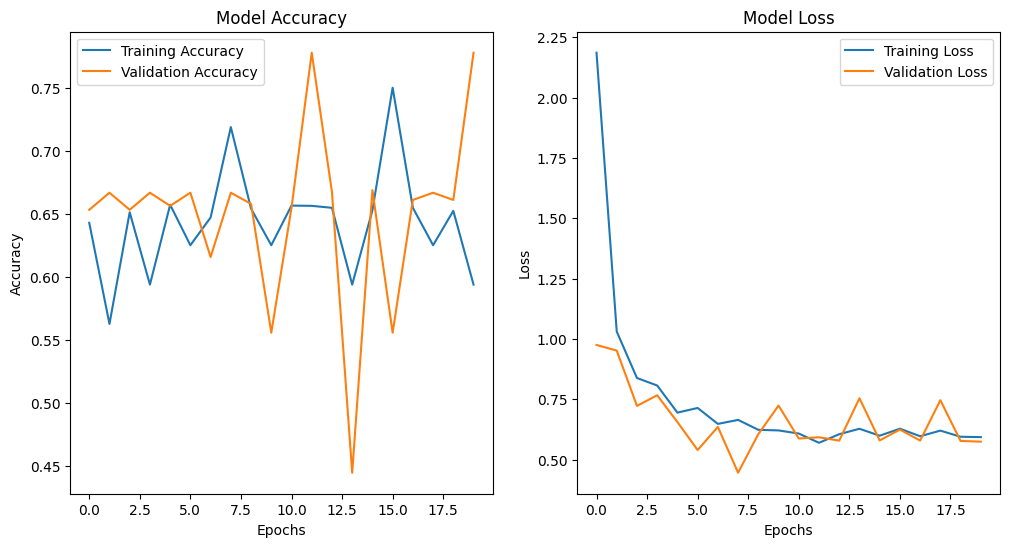

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
#Next Steps for Further Improvement Experiment with Training Duration and Learning Rate:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=20,  # Increased epochs
    validation_data=validation_generator,
    validation_steps=len(val_df) // batch_size,
    callbacks=callbacks_list
)


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.6244 - loss: 1.1204 - val_accuracy: 0.6547 - val_loss: 0.6725 - learning_rate: 0.0100
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.6809 - val_accuracy: 0.4444 - val_loss: 0.6627 - learning_rate: 0.0100
Epoch 3/20


2024-05-05 19:24:17.369457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:24:17.506281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6468 - loss: 0.6750 - val_accuracy: 0.6539 - val_loss: 0.6345 - learning_rate: 0.0100
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.5360 - val_accuracy: 0.5556 - val_loss: 0.6976 - learning_rate: 0.0100
Epoch 5/20


2024-05-05 19:26:46.166664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:26:46.303954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6528 - loss: 0.6428 - val_accuracy: 0.6531 - val_loss: 0.6325 - learning_rate: 0.0100
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 0.6507 - val_accuracy: 0.6667 - val_loss: 0.7402 - learning_rate: 0.0100
Epoch 7/20


2024-05-05 19:29:13.059549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:29:13.197987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6522 - loss: 0.6321 - val_accuracy: 0.6539 - val_loss: 0.6332 - learning_rate: 0.0100
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.6880 - val_accuracy: 0.5556 - val_loss: 0.6124 - learning_rate: 0.0100
Epoch 9/20


2024-05-05 19:31:41.668249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:31:41.810384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 145s 999ms/step - accuracy: 0.6542 - loss: 0.6302 - val_accuracy: 0.6547 - val_loss: 0.6156 - learning_rate: 0.0100
Epoch 10/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.6398 - val_accuracy: 0.4444 - val_loss: 0.7360 - learning_rate: 0.0050
Epoch 11/20


2024-05-05 19:34:07.963106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:34:08.105076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6509 - loss: 0.6065 - val_accuracy: 0.6508 - val_loss: 0.5964 - learning_rate: 0.0050
Epoch 12/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.5787 - val_accuracy: 1.0000 - val_loss: 0.4224 - learning_rate: 0.0050
Epoch 13/20


2024-05-05 19:36:34.656659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:36:34.793892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6603 - loss: 0.6065 - val_accuracy: 0.6523 - val_loss: 0.5881 - learning_rate: 0.0050
Epoch 14/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6562 - loss: 0.5908 - val_accuracy: 0.7778 - val_loss: 0.4830 - learning_rate: 0.0050
Epoch 15/20


2024-05-05 19:39:03.068362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:39:03.204327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 144s 991ms/step - accuracy: 0.6597 - loss: 0.6028 - val_accuracy: 0.6523 - val_loss: 0.6137 - learning_rate: 0.0050
Epoch 16/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.6145 - val_accuracy: 0.7778 - val_loss: 0.5609 - learning_rate: 0.0050
Epoch 17/20


2024-05-05 19:41:28.112905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:41:28.252642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6490 - loss: 0.6079 - val_accuracy: 0.6531 - val_loss: 0.5884 - learning_rate: 0.0050
Epoch 18/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.5524 - val_accuracy: 0.6667 - val_loss: 0.5645 - learning_rate: 0.0050
Epoch 19/20


2024-05-05 19:43:54.864674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:43:55.003880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 145s 998ms/step - accuracy: 0.6632 - loss: 0.5929 - val_accuracy: 0.6547 - val_loss: 0.5957 - learning_rate: 0.0050
Epoch 20/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - loss: 0.6301 - val_accuracy: 0.4444 - val_loss: 0.6083 - learning_rate: 0.0025


2024-05-05 19:46:20.602331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:46:20.739340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [21]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df) // batch_size)
print('Test accuracy:', test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - accuracy: 0.6276 - loss: 0.6168
Test accuracy: 0.6546875238418579


In [22]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [23]:
print("Training Data:")
print(train_df.head())

print("\nValidation Data:")
print(val_df.head())

print("\nTest Data:")
print(test_df.head())

Training Data:
                                            filename class
0  /teamspace/uploads/Augmented Data/aug_Benign_0...     0
1  /teamspace/uploads/Augmented Data/aug_Benign_0...     0
2  /teamspace/uploads/Augmented Data/aug_Normal_0...     1
3  /teamspace/uploads/Augmented Data/aug_Malignan...     1
4  /teamspace/uploads/Augmented Data/aug_Malignan...     1

Validation Data:
                                            filename class
0  /teamspace/uploads/Augmented Data/aug_Benign_0...     0
1  /teamspace/uploads/Augmented Data/aug_Malignan...     1
2  /teamspace/uploads/Augmented Data/aug_Benign_0...     0
3  /teamspace/uploads/Augmented Data/aug_Normal_0...     1
4  /teamspace/uploads/Augmented Data/aug_Malignan...     1

Test Data:
                                            filename class
0  /teamspace/uploads/Augmented Data/aug_Benign_0...     0
1  /teamspace/uploads/Augmented Data/aug_Malignan...     1
2  /teamspace/uploads/Augmented Data/aug_Benign_0...     0
3  /teamspa

In [24]:
#Define the Model with Hyperparameters You'll need to create a function that builds your CNN model with hyperparameters that you want to tune, such as the number of filters in the convolutional layers, dropout rate, and the learning rate of the optimizer.
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(img_width, img_height, 3)
        ),
        MaxPooling2D(2, 2),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
            activation='relu'
        ),
        Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [25]:
#Configure the Tuner and Start the Search You can use different types of tuners available in Keras Tuner like RandomSearch, Hyperband, etc. Here, I'll use the Hyperband tuner which is a more efficient approach, based on the Hyperband algorithm.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='lung_cancer_detection'
)

# Create a callback to stop training early after reaching a certain value for validation loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(val_df) // batch_size,
    callbacks=[stop_early]
)


Reloading Tuner from my_dir/lung_cancer_detection/tuner0.json


In [26]:
# Get the top 3 models.
models = tuner.get_best_models(num_models=3)

# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The best number of filters in the first conv layer: {best_hps.get('conv_1_filters')}
The best dropout rate after the first conv layer: {best_hps.get('dropout_1')}
The best number of filters in the second conv layer: {best_hps.get('conv_2_filters')}
The best number of units in the dense layer: {best_hps.get('dense_units')}
The best dropout rate after the dense layer: {best_hps.get('dropout_2')}
The best learning rate for the optimizer: {best_hps.get('learning_rate')}
""")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages


The best number of filters in the first conv layer: 64
The best dropout rate after the first conv layer: 0.4
The best number of filters in the second conv layer: 64
The best number of units in the dense layer: 384
The best dropout rate after the dense layer: 0.2
The best learning rate for the optimizer: 0.0002498371968825151



In [27]:
#Now that you have the best hyperparameters, construct and train the model using these settings for the full training set, or even for more epochs, to potentially squeeze out more performance.

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(384, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002498371968825151),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=16,  # Increased epochs
    validation_data=validation_generator,
    validation_steps=len(val_df) // batch_size
)


Epoch 1/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6169 - loss: 0.8485 - val_accuracy: 0.6664 - val_loss: 0.5810
Epoch 2/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.5938 - loss: 0.5820 - val_accuracy: 0.7778 - val_loss: 0.5237
Epoch 3/16


2024-05-05 19:49:52.240837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-05 19:49:52.310598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6570 - loss: 0.5543 - val_accuracy: 0.6633 - val_loss: 0.5493
Epoch 4/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.5938 - loss: 0.6108 - val_accuracy: 0.5556 - val_loss: 0.5016
Epoch 5/16


2024-05-05 19:52:59.234236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:52:59.298683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6680 - loss: 0.5383 - val_accuracy: 0.6727 - val_loss: 0.5445
Epoch 6/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.7188 - loss: 0.4245 - val_accuracy: 0.7778 - val_loss: 0.5489
Epoch 7/16


2024-05-05 19:56:09.915157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:56:09.980400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6585 - loss: 0.5436 - val_accuracy: 0.6742 - val_loss: 0.5400
Epoch 8/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.8438 - loss: 0.3789 - val_accuracy: 0.6667 - val_loss: 0.6094
Epoch 9/16


2024-05-05 19:59:18.144826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 19:59:18.209384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6689 - loss: 0.5327 - val_accuracy: 0.6742 - val_loss: 0.5359
Epoch 10/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.7188 - loss: 0.5257 - val_accuracy: 0.7778 - val_loss: 0.6115
Epoch 11/16


2024-05-05 20:02:26.981919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 20:02:27.045260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6571 - loss: 0.5336 - val_accuracy: 0.6742 - val_loss: 0.5336
Epoch 12/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.6875 - loss: 0.4973 - val_accuracy: 0.5556 - val_loss: 0.6165
Epoch 13/16


2024-05-05 20:05:33.621437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 20:05:33.686584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6653 - loss: 0.5323 - val_accuracy: 0.6461 - val_loss: 0.5339
Epoch 14/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.7812 - loss: 0.4553 - val_accuracy: 0.8889 - val_loss: 0.3201
Epoch 15/16


2024-05-05 20:08:41.463349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 20:08:41.527566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


142/142 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6631 - loss: 0.5269 - val_accuracy: 0.6641 - val_loss: 0.5337
Epoch 16/16
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.6562 - loss: 0.5064 - val_accuracy: 0.8889 - val_loss: 0.3126


2024-05-05 20:11:48.041170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 20:11:48.105478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [28]:
# Predict probabilities for the test set
predictions = model.predict(test_generator, steps=len(test_df) // batch_size)
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary classes

# Get actual classes from the test generator
actual_classes = test_generator.classes[:len(predicted_classes)]


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step


In [29]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df) // batch_size)
print('Test accuracy:', test_acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.6197 - loss: 0.5603
Test accuracy: 0.6156250238418579


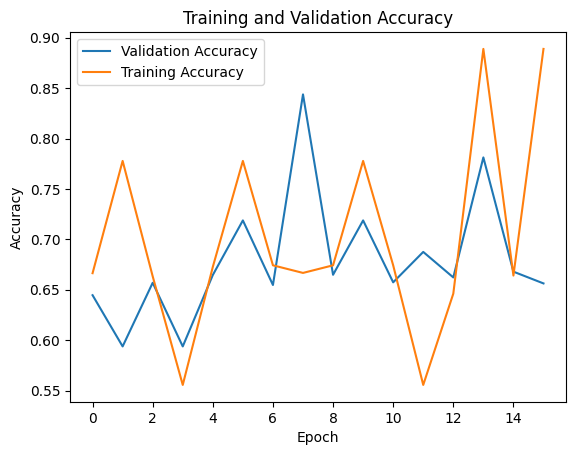

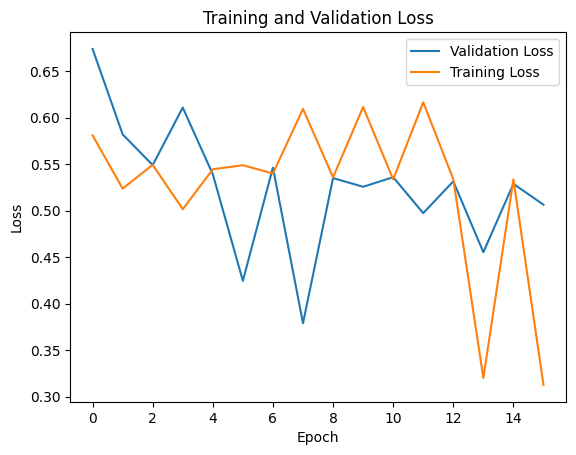

Final Training Accuracy: 0.8888888955116272
Final Validation Accuracy: 0.65625


In [30]:

# Print accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Validation Accuracy')
plt.plot(val_accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Validation Loss')
plt.plot(val_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print final accuracy
final_train_accuracy = train_accuracy[-1]
final_val_accuracy = val_accuracy[-1]
print("Final Training Accuracy:", final_val_accuracy)
print("Final Validation Accuracy:", final_train_accuracy)


Precision: 0.8502
Recall: 0.5012
F1 Score: 0.6306
ROC AUC Score: 0.7393


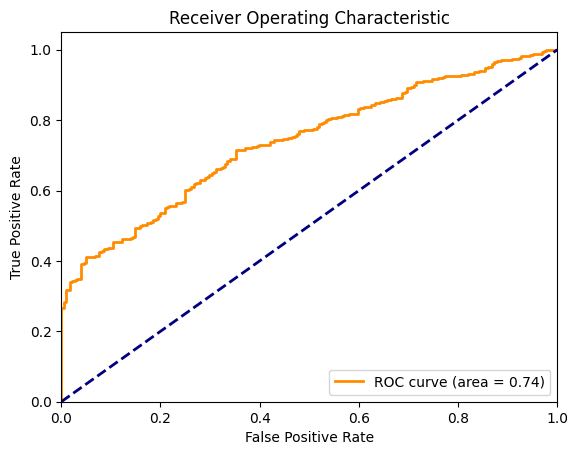

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate precision, recall, and F1-score
precision = precision_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)

# Calculate the AUC score
roc_auc = roc_auc_score(actual_classes, predictions)  # Note: Use probabilities here for AUC

# Print the computed metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(actual_classes, predictions)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score


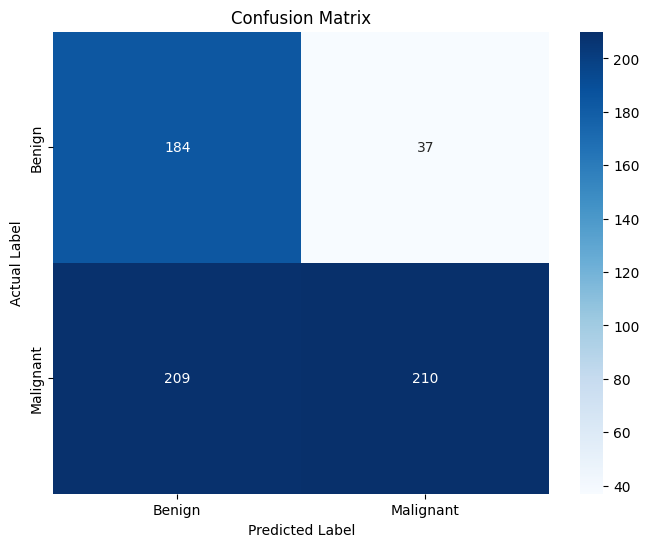

In [33]:
# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


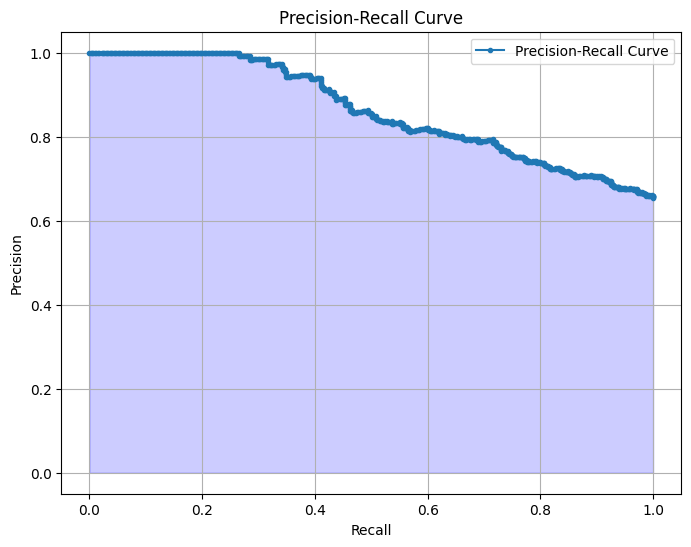

Average Precision Score: 0.8631


In [34]:
precision, recall, thresholds = precision_recall_curve(actual_classes, predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the average precision score
ap_score = average_precision_score(actual_classes, predictions)
print(f"Average Precision Score: {ap_score:.4f}")


In [35]:
def load_and_preprocess_image(img_path):
    # Load the image file, resizing it to the dimensions expected by the model
    img = image.load_img(img_path, target_size=(img_width, img_height))
    
    # Display the image
    plt.imshow(img)
    plt.title("Loaded Image")
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Model expects batches, so expand dimensions to include batch size
    
    # Normalize the image array
    img_array /= 255.0
    
    return img_array

def predict_image(model, img_array):
    # Predict the probability of the image belonging to the malignant class
    prediction = model.predict(img_array)
    predicted_class = 'Malignant' if prediction[0] > 0.5 else 'Benign'
    return predicted_class, prediction[0]


In [36]:
from tensorflow.keras.utils import plot_model


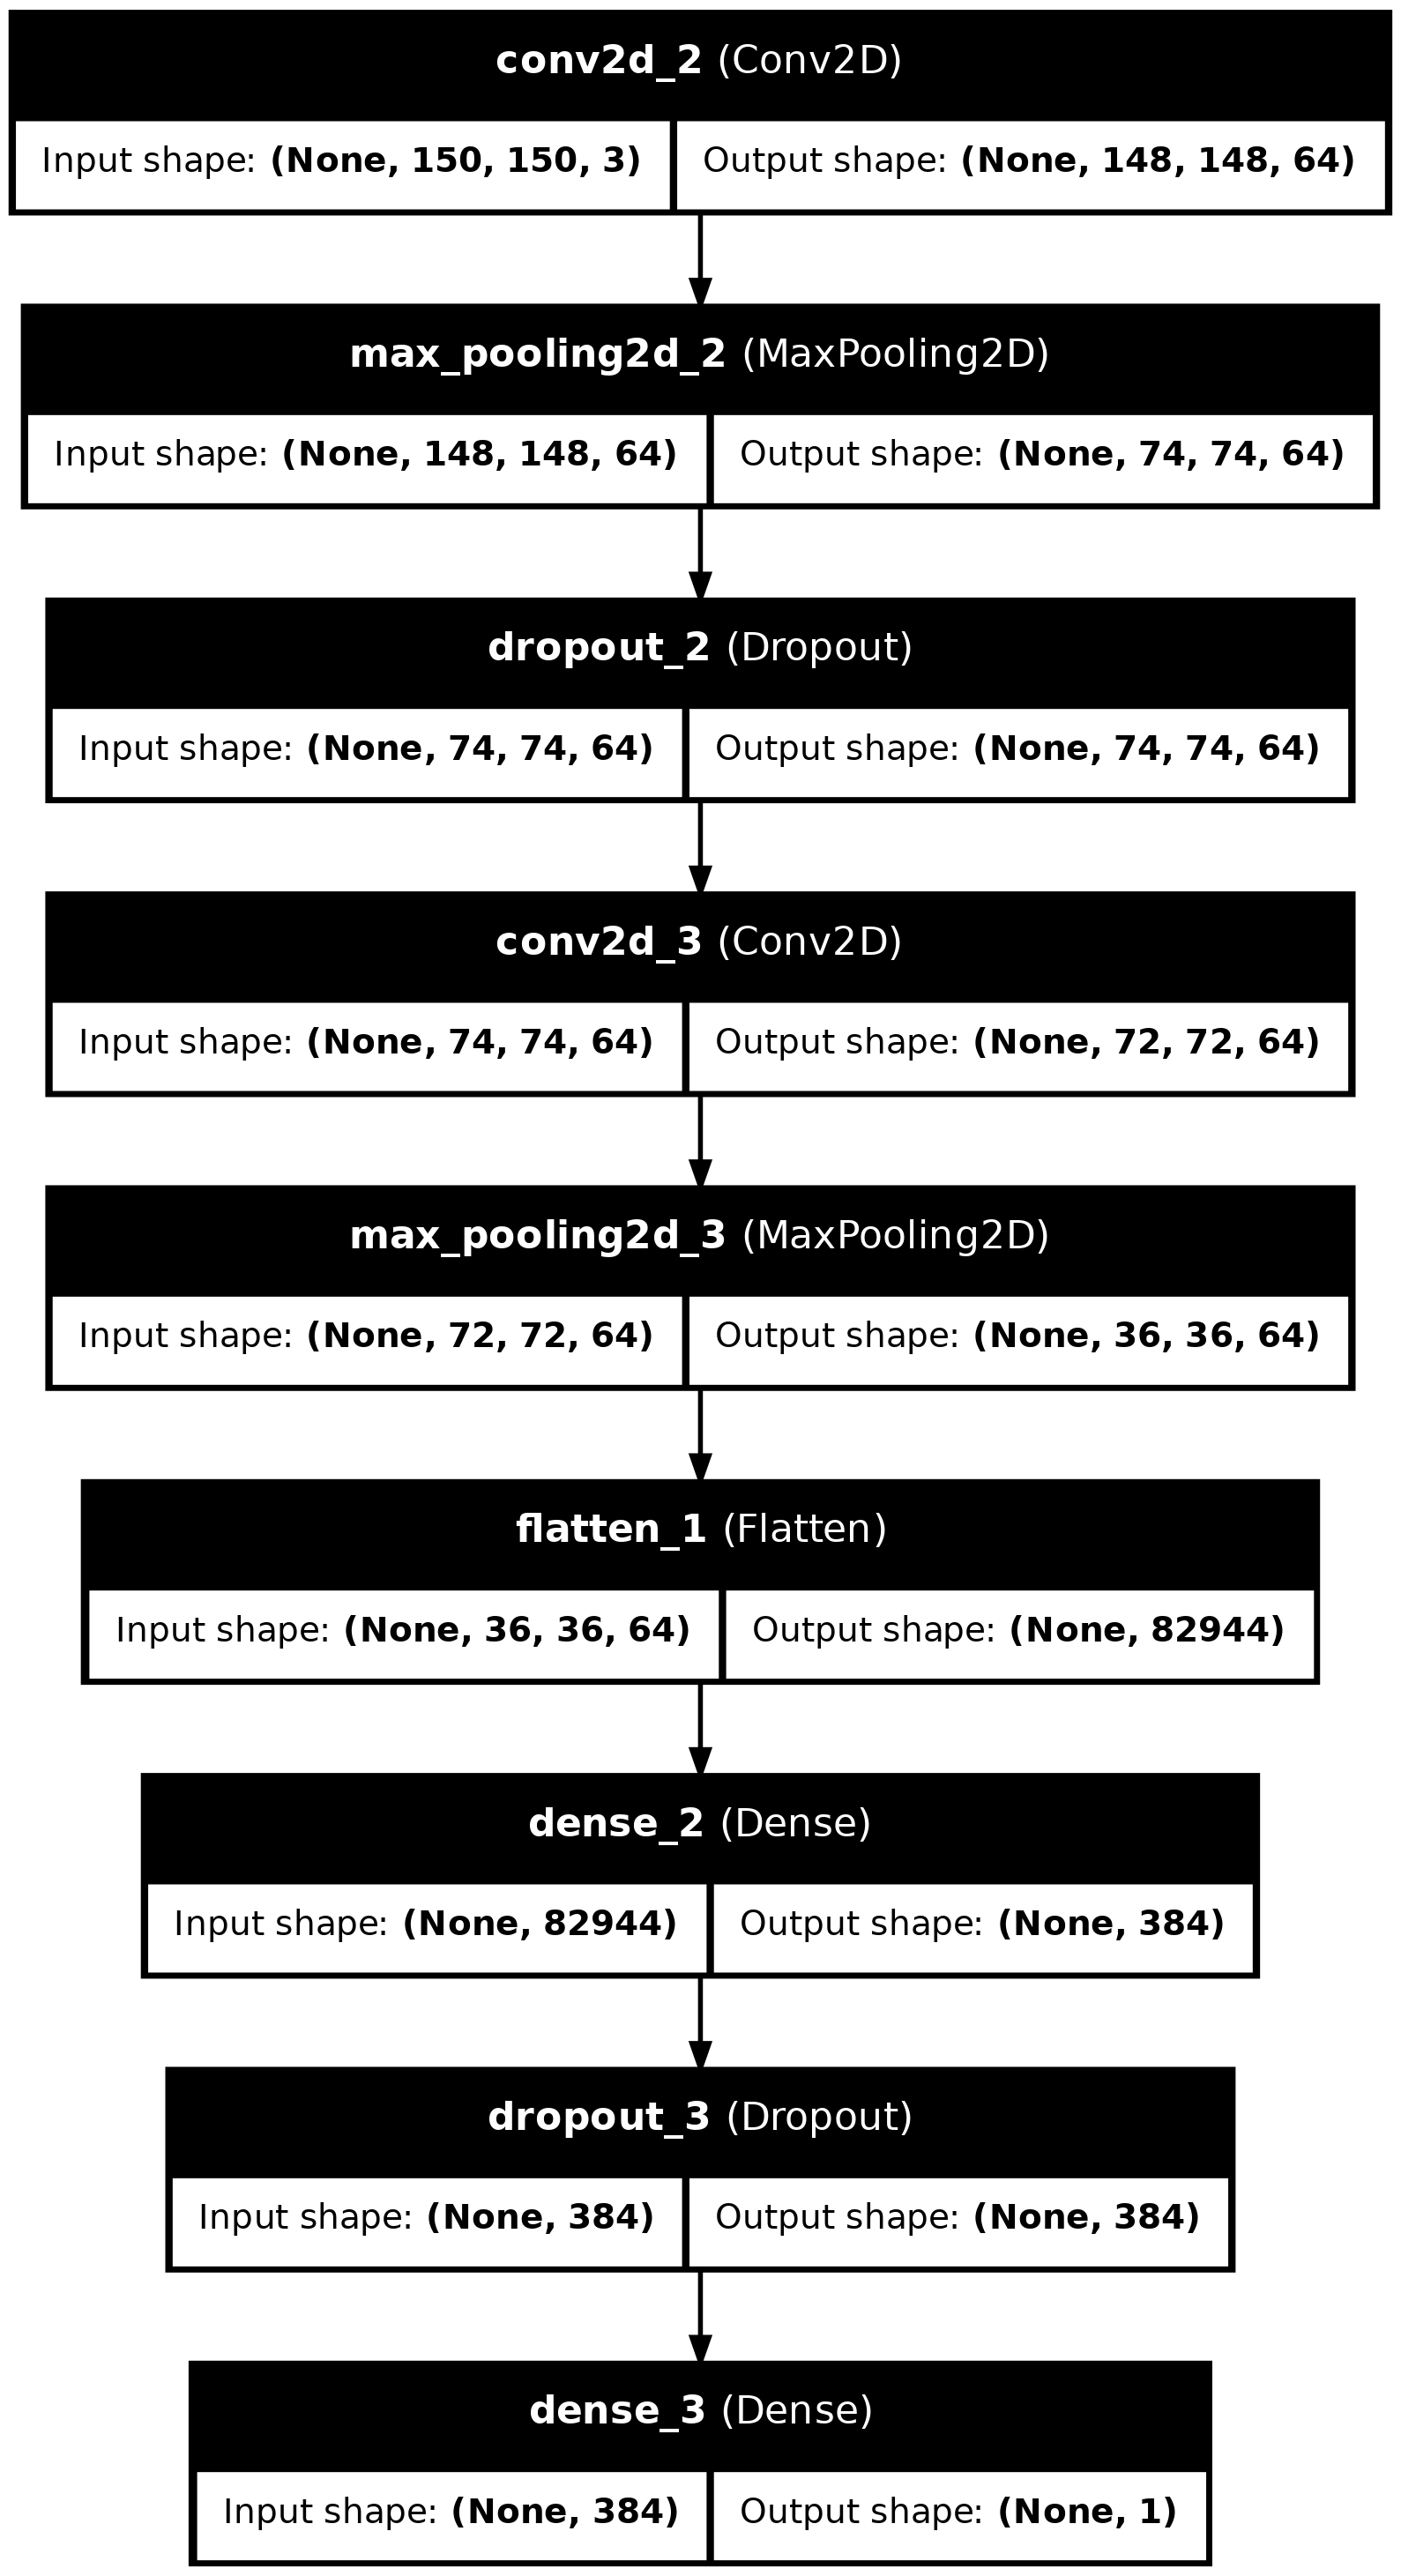

In [37]:
# Generate the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# This saves the model architecture diagram to a file 'model_plot.png' and optionally displays the shapes of the layers


In [38]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002498371968825151),
    loss='binary_crossentropy',
    metrics=['accuracy', 'mse']  # Ensure 'mse' is included here
)


In [40]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │    31,850,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,889,985 (121.65 MB)

 Trainable params: 31,889,985 (121.65 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
results = model.evaluate(test_generator, steps=len(test_df) // batch_size)
print('Test Loss:', results[0])
print('Test Accuracy:', results[1])
print('Test MSE:', results[2])


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.6197 - loss: 0.5603 - mse: 0.1994
Test Loss: 0.5604647397994995
Test Accuracy: 0.6156250238418579
Test MSE: 0.19946670532226562


In [42]:
from sklearn.metrics import r2_score

# Assuming 'predictions' are the probability outputs of your model
# and 'actual_classes' are the actual binary labels
r2 = r2_score(actual_classes, predictions)
print("R-squared Score:", r2)


R-squared Score: 0.11768416241008306


In [43]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(actual_classes, predictions)
print("Brier Score:", brier_score)


Brier Score: 0.19946670958249196


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss

predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold

accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)
brier_score = brier_score_loss(actual_classes, predictions)


In [45]:
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Brier Score': brier_score
}


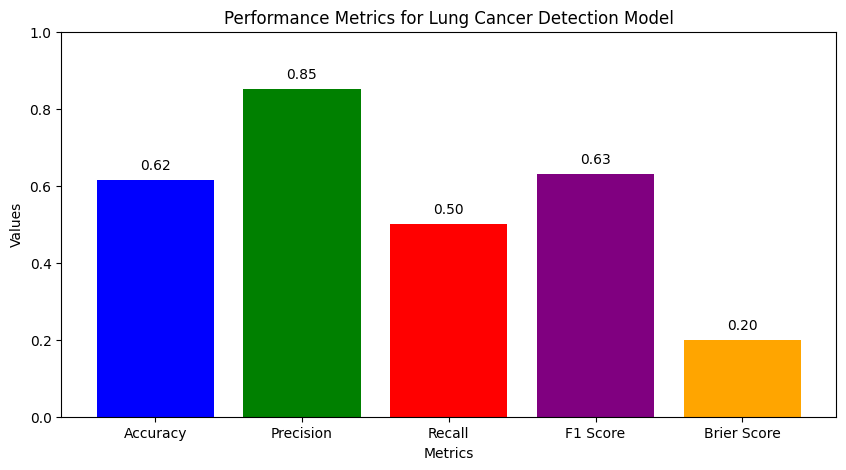

In [46]:
import matplotlib.pyplot as plt

# Names of the metrics
metric_names = list(metrics.keys())
# Values of the metrics
metric_values = [metrics[name] for name in metric_names]

plt.figure(figsize=(10, 5))
plt.bar(metric_names, metric_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics for Lung Cancer Detection Model')
plt.ylim([0, 1])  # Since metrics like accuracy, Brier score are between 0 and 1
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.show()
